In [1]:
import requests
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import shutil
from PIL import Image

from sklearn.model_selection import train_test_split

In [2]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, n_informative=2, random_state=42)
X_multi, y_multi = make_classification(n_samples=500, n_features=6, n_classes=3, n_informative=6,
                                      n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42,
                                                       stratify=y_multi)


X_train, X_test, y_train, y_test = pd.DataFrame(X_train).to_dict(), pd.DataFrame(X_test).to_dict(), \
                                   pd.DataFrame(y_train).to_dict(), pd.DataFrame(y_test).to_dict()

Xm_train, Xm_test, ym_train, ym_test = pd.DataFrame(Xm_train).to_dict(), pd.DataFrame(Xm_test).to_dict(), \
                                       pd.DataFrame(ym_train).to_dict(), pd.DataFrame(ym_test).to_dict()

# 1. Доступные типы моделей:

In [3]:
print(requests.get('http://127.0.0.1:5000/api/model_types').text)

Available model types: ['LogisticRegression (LR)', 'Boosting (LGBM)']


# 2. Создание моделей

### 2.1 Корректный запрос, но с ошибкой в переменной

In [4]:
print(requests.post('http://127.0.0.1:5000/api/create_model', json={
    'model_type': 'LR',
    'model_nae': 'LR',
    'dataset_name': 'binary'
}).text)

print(requests.post('http://127.0.0.1:5000/api/create_model', json={
    'model_type': 'boosting',
    'dataset_name': 'multiclass'
}).text)

print(requests.post('http://127.0.0.1:5000/api/create_model', json={
    'model_name': 'fit_test',
    'model_type': 'LogisticRegression (LR)'
}).text)

Success
Success
Success


### 2.2 Некорректный запрос

In [5]:
print(requests.post('http://127.0.0.1:5000/api/create_model', json={
    'model_type': 'Tree',
    'model_name': 'test_name',
    'dataset_name': 'test_name'
}).text)

Wrong model type Tree
Available model types: ['LogisticRegression (LR)', 'Boosting (LGBM)']


# 3. Принт доступных моделей

### 3.1 Несуществующая модель

In [6]:
r = requests.get('http://127.0.0.1:5000/api/get_model/20')
try: 
    print(r.json())
except:
    print(r.text)

Model with id - 20 doesnt exist


### 3.2. Правильный id модели

In [7]:
requests.get('http://127.0.0.1:5000/api/get_model/2').json()

{'dataset_name': 'binary',
 'model': 'Not fitted',
 'model_id': 2,
 'model_name': '',
 'model_params': {'random_state': 42},
 'model_type': 'LogisticRegression (LR)',
 'scores': {}}

# 4. Обновление модели

### 4.1. Вызов без словаря

In [8]:
print(requests.put('http://127.0.0.1:5000/api/update_model').text)

Dictionary should be passed.


### 4.2. Вызов с некорректным словарем

In [9]:
print(requests.put('http://127.0.0.1:5000/api/update_model', json={
    'model_type': 'test',
    'dataset_name': 'multi_class'
}).text)

Incorrect dictionary passed.


### 4.3 Корректный вызов

In [10]:
print(requests.put('http://127.0.0.1:5000/api/update_model', json={
    'model_id': 1,
    'model_type': 'test',
    'dataset_name': 'test_2'
}).text)

Success, but ["Model attributes: ['model_type'] is not allowed to change"]


# 5. Удаление модели

### 5.1 Correct

In [11]:
print(requests.delete('http://127.0.0.1:5000/api/delete_model/1').text)

Success


### 5.2 Incorrect

In [12]:
print(requests.delete('http://127.0.0.1:5000/api/delete_model/5').text)

Success


# 6. Установление гиперпараметров вручную

### 6.1 Корректные гиперпараметры

In [13]:
print(requests.put('http://127.0.0.1:5000/api/set_model_params/2', json={'C': 2}).text)

Success


### 6.2 Некорректные гиперпараметры

In [14]:
print(requests.put('http://127.0.0.1:5000/api/set_model_params/2', json={'abc': -1}).text)

Wrong params for model


# 7. Доступные для оптимазации гиперпараметры

### 7.1 Корректный тип модели

In [15]:
requests.get('http://127.0.0.1:5000/api/available_opt_params', json={'model_type': 'LR'}).json()

['C', 'tol', 'max_iter']

### 7.2 Некорректный тип модели

In [16]:
print(requests.get('http://127.0.0.1:5000/api/available_opt_params', json={'model_type': 'Tree'}).text)

Wrong model type Tree 
Available model types: ['LogisticRegression (LR)', 'Boosting (LGBM)']


### 7.3 Ввод без словаря

In [17]:
print(requests.get('http://127.0.0.1:5000/api/available_opt_params').text)

Dictionary should be passed  
Available model types: ['LogisticRegression (LR)', 'Boosting (LGBM)']


# 8. Оптимизация гиперпараметров

### 8.1 Правильная передача гиперпараметров

In [18]:
params_to_optimaze = {'C': [0, 10],
                      'tol': [0.000001, 0.01],
                      'max_iter': [10, 1000]}

json = {'X': X_train,
        'y': y_train,
        'metric': 'auc_roc',
        'params_to_optimaze':params_to_optimaze}

requests.get('http://127.0.0.1:5000/api/optimize_model_params/2', json=json).json()

{'params': {'C': 9.326025198925741,
  'max_iter': 310,
  'tol': 0.00015262252469876934},
 'score': 0.531174807587123}

In [19]:
params_to_optimaze = {
'boosting_type': ['goss'],
'n_estimators': [10, 100],
'learning_rate': [0.1, 0.2], 
'num_leaves': [10, 100],
'max_depth': [1, 10],  
'min_child_weight': [2, 100], 
'reg_alpha': [0.1, 0.2], 
'reg_lambda': [0.1, 0.2]
}

json = {'X': Xm_train,
        'y': ym_train,
        'metric': 'auc_pr',
        'params_to_optimaze': params_to_optimaze,
       'max_trails': 10}

requests.get('http://127.0.0.1:5000/api/optimize_model_params/3', json=json).json()

{'params': {'boosting_type': 'goss',
  'learning_rate': 0.19830208668523405,
  'max_depth': 9,
  'min_child_weight': 17,
  'n_estimators': 44,
  'n_jobs': 1,
  'num_leaves': 87,
  'reg_alpha': 0.13925292439465875,
  'reg_lambda': 0.10934603745586503},
 'score': 0.36901908889477897}

### 8.2 Неправильная передача гиперпараметров

In [20]:
params_to_optimaze = {'C': [1, 1, 1]}

json = {'X': X_train,
       'y': y_train,
       'metric': 'f1',
       'params_to_optimaze': params_to_optimaze}


requests.get('http://127.0.0.1:5000/api/optimize_model_params/1', json=json).text

'Model with id - 1 doesnt exist'

# 9. fit

### 9.1 Correct

In [21]:
print(requests.put('http://127.0.0.1:5000/api/fit/2', json={'X': X_train, 'y': y_train}).text)
print(requests.put('http://127.0.0.1:5000/api/fit/3', json={'X': Xm_train, 'y': ym_train}).text)

Success
Success


### 9.2 Incorrect

In [22]:
print(requests.put('http://127.0.0.1:5000/api/fit/100', json={'X': X_train, 'y': y_train}).text)

Model with id - 100 doesnt exist


In [23]:
print(requests.put('http://127.0.0.1:5000/api/fit/1', json={'X': X_train, 'y': X_train}).text)

Model with id - 1 doesnt exist


# 10. predict

### 10.1 Correct

In [24]:
preds = requests.put('http://127.0.0.1:5000/api/predict/3', json={'X': Xm_test}).json()

### 10.2 Incorrect

In [25]:
print(requests.put('http://127.0.0.1:5000/api/predict/4', json={'X': X_test}).text)

Model not fitted yet, fit first


# 11. predict_proba

### 11.1 Correct

In [26]:
preds_proba = requests.put('http://127.0.0.1:5000/api/predict_proba/3', json={'X': Xm_test}).json()
preds_proba = requests.put('http://127.0.0.1:5000/api/predict_proba/2', json={'X': X_test}).json()

### 11.2 Incorrect

In [27]:
print(requests.put('http://127.0.0.1:5000/api/predict/4', json={'X': X_test}).text)

Model not fitted yet, fit first


In [28]:
requests.put('http://127.0.0.1:5000/api/predict/4', json={'X': X_test}).text

'Model not fitted yet, fit first'

# 12. получение метрик качеств

### 12.1 Correct

In [29]:
json = {'y_true': y_test, 
        'y_predicted': preds_proba, 
        'plot':True}

requests.get('http://127.0.0.1:5000/api/get_scores/2', json=json).json()

{'dataset_name': 'binary',
 'model': 'Fitted',
 'model_id': 2,
 'model_name': '',
 'model_params': {'C': 9.326025198925741,
  'max_iter': 310,
  'tol': 0.00015262252469876934},
 'model_type': 'LogisticRegression (LR)',
 'scores': {'ROC_AUC': 0.05780578057805782,
  'ROC_PR': 0.30886621716046253,
  'accuracy': 0.14,
  'f1': 0.13784461152882205,
  'precision': 0.13614738333839457,
  'recall': 0.1405140514051405}}

In [30]:
json = {'y_true': ym_test, 
        'X': Xm_test}

requests.get('http://127.0.0.1:5000/api/get_scores/3', json=json).json()

{'dataset_name': 'multiclass',
 'model': 'Fitted',
 'model_id': 3,
 'model_name': '',
 'model_params': {'boosting_type': 'goss',
  'learning_rate': 0.19830208668523405,
  'max_depth': 9,
  'min_child_weight': 17,
  'n_estimators': 44,
  'n_jobs': 1,
  'num_leaves': 87,
  'random_state': 42,
  'reg_alpha': 0.13925292439465875,
  'reg_lambda': 0.10934603745586503},
 'model_type': 'Boosting (LGBM)',
 'scores': {'accuracy': 0.4,
  'f1': 0.4044899817850638,
  'precision': 0.4150793650793651,
  'recall': 0.40047534165181226}}

### 12.2 Incorrect

In [31]:
json = {'y_true': ym_test,
       'plot': True}

print(requests.get('http://127.0.0.1:5000/api/get_scores/3', json=json).text)

At least y_predicted or X should be filled


# 13. AUC plot

### 13.1 Correct

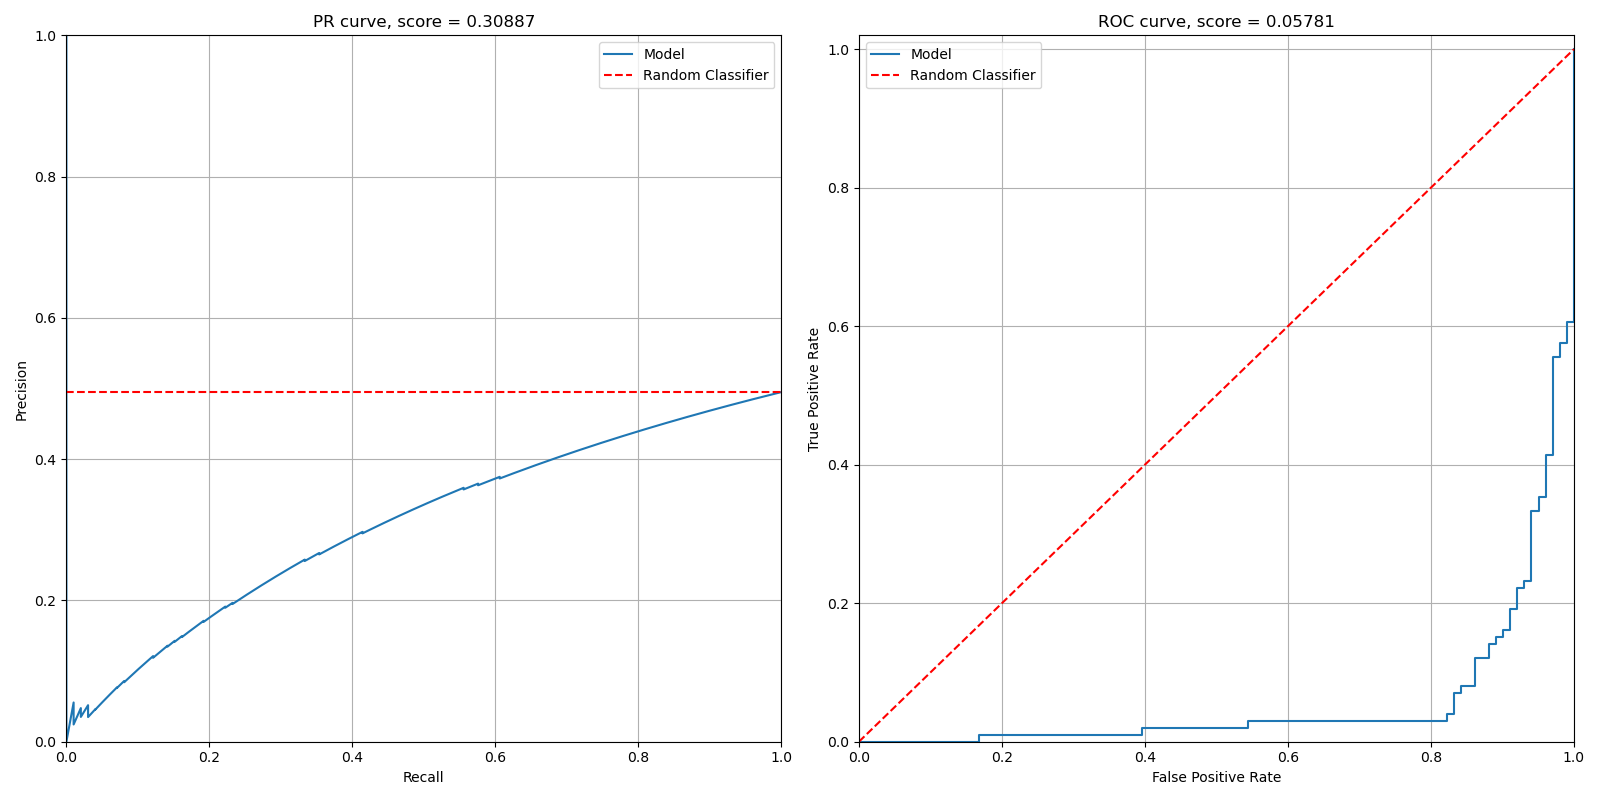

In [32]:
image = requests.get('http://127.0.0.1:5000/api/get_auc_plot/2', stream=True)

with open('AUC_model_1.png', 'wb') as out_file:
    shutil.copyfileobj(image.raw, out_file)
    
im = Image.open("AUC_model_1.png")
im

### 13.2 Incorrect

In [33]:
print(requests.get('http://127.0.0.1:5000/api/get_auc_plot/3', stream=True).text)

get_scores should be called first (only for binary task)
